In [1]:
import flashbax as fbx
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import jax
from jax import lax,random
from jax import numpy as jnp
from tqdm.auto import tqdm
import jax.numpy as jnp
import haiku as hk
import optax
import rlax
import timeit
import distrax
import chex
from jumanji.wrappers import AutoResetWrapper
import jumanji

print("The following devices are available: ", jax.devices())

The following devices are available:  [CpuDevice(id=0)]


In [2]:
@chex.dataclass(frozen=True)
class TimeStep:
    observation: chex.Array
    action: chex.Array
    discount: chex.Array
    reward: chex.Array


@chex.dataclass(frozen=True)
class Params:
    online: hk.Params
    target: hk.Params
    update_count: int

def process_observation(timestep: TimeStep) -> jnp.ndarray:
    """Concatenates and flatten the observation"""
    return jnp.concatenate(
        [
            timestep.observation.weights,
            timestep.observation.values,
            timestep.observation.packed_items,
            timestep.observation.action_mask,
        ]
    )

In [3]:
def get_network_fn(num_outputs: int):
    def network_fn(obs: chex.Array) -> chex.Array:
        """Outputs action logits."""
        network = hk.Sequential(
            [
            # hk.Conv2D(32, kernel_shape=2, stride=1),
            # jax.nn.relu,
            # hk.Conv2D(32, kernel_shape=2, stride=1),
            # jax.nn.relu,
            # hk.Flatten(),
            hk.Linear(64),
            jax.nn.relu,
            hk.Linear(128),
            jax.nn.relu,
            hk.Linear(num_outputs),
            ]
        )
        return network(obs)

    return hk.without_apply_rng(hk.transform(network_fn))


def get_learner_fn(
    env,
    forward_pass,
    buffer_fn,
    opt_update,
    rollout_len,
    agent_discount,
    iterations,
    target_period,
    epsilon_schedule_fn,
    sgd_steps_per_rollout,
    importance_sampling_exponent,
):
    """Returns a learner function that can be used to update parameters."""

    def rollout(params_state, outer_rng, env_state, env_timestep):
        """Collects a trajectory from the environment."""
        def step_fn(env_data, rng):
            """Steps the environment and collects transition data."""
            (env_state, env_timestep, params_state) = env_data
            obs_tm1 = process_observation(env_timestep)
            d_tm1 = env_timestep.discount
            q_values_tm1 = forward_pass(params_state.online, jnp.expand_dims(obs_tm1, 0))
            a_tm1_dist = distrax.EpsilonGreedy(preferences=q_values_tm1[0], epsilon=epsilon_schedule_fn(params_state.update_count))
            a_tm1 = a_tm1_dist.sample(seed=rng)
            new_env_state, new_env_timestep = env.step(env_state, a_tm1)  #
            r_t = new_env_timestep.reward
            return (
                new_env_state,
                new_env_timestep,
                params_state,
            ), TimeStep(  # return env state and transition data.
                observation=obs_tm1, action=a_tm1, discount=d_tm1, reward=r_t
            ) # We line up the observation with its discount, not the discount of the next observation as is usually seen.
              # This is so that we know in a transition that discount[1] is the discount of the next observation.
              # e.g. indexing is v[t] = reward[t] + discount[t+1]*value[t+1]
              # Switching to Sutton and Barto's notation, we would have v[t] = reward[t+1] + discount[t+1]*value[t+1]
              # To do this, we would add r_tm1 = env_timestep.reward to the TimeStep dataclass, not the new_env_timestep.reward

        step_rngs = jax.random.split(outer_rng, rollout_len)
        (env_state, env_timestep, params_state), rollout = lax.scan(
            step_fn, (env_state, env_timestep, params_state), step_rngs
        )  # trajectory.

        return rollout, env_state, env_timestep

    def loss_fn(params, target_params, batch):
        """Computes the loss for a single batch."""
        # For ease of reading
        o_tm1 = batch.experience.first.observation
        a_tm1 = batch.experience.first.action.astype(jnp.int32)
        r_t = batch.experience.first.reward
        d_t = agent_discount * batch.experience.second.discount
        o_t = batch.experience.second.observation
        # Compute Q-values for current and next states.
        q_tm1 = forward_pass(params, o_tm1)
        q_t = forward_pass(target_params, o_t)
        q_t_select = forward_pass(params, o_t)
        # Compute the TD-error.
        td_error = jax.vmap(
            rlax.double_q_learning
        )(  # compute multi-step temporal diff error.
            q_tm1=q_tm1,  # predictions.
            a_tm1=a_tm1,  # actions.
            r_t=r_t,  # rewards.
            discount_t=d_t,  # discount.
            q_t_value=q_t,  # target values.
            q_t_selector=q_t_select,  # selector values.
        )

        batch_loss = rlax.l2_loss(td_error)  # compute L2 loss.

        # Get the importance weights.
        importance_weights = (1. / batch.priorities).astype(jnp.float32)
        importance_weights **= importance_sampling_exponent
        importance_weights /= jnp.max(importance_weights)

        # Reweight.
        loss = jnp.mean(importance_weights * batch_loss)
        new_priorities = jnp.abs(td_error) + 1e-7
        return loss, new_priorities

    def update_fn(
        params_state: Params, buffer_state, opt_state, rng, env_state, env_timestep
    ):
        """Updates the parameters of the agent."""
        rng, rollout_rng, update_rng = random.split(rng, 3)

        data_rollout, new_env_state, new_env_timestep = rollout(
            params_state, rollout_rng, env_state, env_timestep
        )  # collect trajectory from environment. This could be one step, or many steps.

        buffer_state = buffer_fn.add(buffer_state, data_rollout)  # store trajectory in buffer.

        def sgd_step(carry, rng):
            """Performs a single SGD step."""
            params_state, opt_state, buffer_state = carry

            batch = buffer_fn.sample(buffer_state, rng)  # sample batch from buffer.

            params, target_params = params_state.online, params_state.target
            grads, new_priorities = jax.grad(loss_fn, has_aux=True)(  # compute gradient on a single trajectory.
                params, target_params, batch
            )
            grads = lax.pmean(grads, axis_name="j")  # reduce mean across cores.
            grads = lax.pmean(grads, axis_name="i")  # reduce mean across batch.
            updates, new_opt_state = opt_update(grads, opt_state)  # transform grads.
            new_params = optax.apply_updates(params, updates)  # update parameters.
            target_params = optax.periodic_update(  # update target parameters.
                new_params, target_params, params_state.update_count + 1, target_period
            )
            new_params_state = Params(  # update parameters state.
                online=new_params,
                target=target_params,
                update_count=params_state.update_count + 1,
            )

            buffer_state = buffer_fn.set_priorities(buffer_state, batch.indices, new_priorities)  # update priorities.

            return (new_params_state, new_opt_state, buffer_state), None

        real_update_fn = lambda p_state, o_state, b_state, rng: jax.lax.scan(sgd_step, (p_state, o_state, b_state), jax.random.split(rng, sgd_steps_per_rollout))[0]
        fake_update_fn = lambda p_state, o_state, b_state, _: (p_state, o_state, b_state)

        new_params_state, new_opt_state, buffer_state = jax.lax.cond(  # conditional update.
            buffer_fn.can_sample(buffer_state),  # if buffer can sample.
            real_update_fn,  # perform update.
            fake_update_fn,  # else do nothing.
            params_state,
            opt_state,
            buffer_state,
            update_rng,
        )

        return (
            new_params_state,
            buffer_state,
            new_opt_state,
            rng,
            new_env_state,
            new_env_timestep,
        )

    def learner_fn(
        params_state: Params, buffer_state, opt_state, rngs, env_states, env_timesteps
    ):
        """Performs multiple SGD steps."""
        batched_update_fn = jax.vmap(
            update_fn, axis_name="j"
        )  # vectorize across batch.

        def iterate_fn(_, val):  # repeat many times to avoid going back to Python.
            params_state, buffer_state, opt_state, rngs, env_states, env_timesteps = val
            return batched_update_fn(
                params_state, buffer_state, opt_state, rngs, env_states, env_timesteps
            )

        return lax.fori_loop(
            0,
            iterations,
            iterate_fn,
            (params_state, buffer_state, opt_state, rngs, env_states, env_timesteps),
        )

    return learner_fn

In [4]:

def set_up_experiment(
    env,
    batch_size,
    step_size,
    seed,
    buffer_size,
    epsilon_init,
    epsilon_final,
    epsilon_steps,
    priority_exponent,
):
    """Sets up the experiment."""
    cores_count = len(jax.devices())  # get available TPU cores.
    network = get_network_fn(env.action_spec().num_values)  # define network.
    optim = optax.adam(step_size)  # define optimiser.

    rng, rng_e, rng_p = random.split(random.PRNGKey(seed), num=3)  # prng keys.
    _, timestep = env.reset(rng_e)
    obs = process_observation(timestep)
    dummy_obs = jnp.expand_dims(obs, 0)  # dummy for net init.
    params = network.init(rng_p, dummy_obs)  # initialise params.
    opt_state = optim.init(params)  # initialise optimiser stats.
    buffer_fn = fbx.make_prioritised_flat_buffer(
        max_length=buffer_size,
        min_length=batch_size,
        sample_batch_size=batch_size,
        add_sequences=True,
        add_batch_size=None,
        priority_exponent=priority_exponent,
    )
    buffer_state = buffer_fn.init(
        TimeStep(
            observation=obs,
            action=jnp.zeros((), dtype=jnp.int32),
            reward=jnp.zeros(()),
            discount=jnp.zeros(()),
        )
    )  # initialise buffer state.
    epsilon_schedule_fn = optax.linear_schedule(
        epsilon_init, epsilon_final, epsilon_steps
    )  # define epsilon schedule.
    return (
        cores_count,
        network,
        optim,
        params,
        opt_state,
        buffer_fn,
        buffer_state,
        rng,
        epsilon_schedule_fn,
    )


def get_rng_keys(cores_count, num_envs, rng):
    """Returns a batch of random number generator keys."""
    rng, *step_rngs = jax.random.split(rng, cores_count * num_envs + 1)
    reshape = lambda x: x.reshape((cores_count, num_envs) + x.shape[1:])
    step_rngs = reshape(jnp.stack(step_rngs))  # add dimension to pmap over.
    return rng, step_rngs


def broadcast_to_device_shape(
    cores_count, num_envs, params, opt_state, buffer_state, rng
):
    """Broadcasts parameters to device shape."""
    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, num_envs) + x.shape)
    params = jax.tree_map(broadcast, params)  # broadcast to cores and batch.
    opt_state = jax.tree_map(broadcast, opt_state)  # broadcast to cores and batch
    buffer_state = jax.tree_map(broadcast, buffer_state)  # broadcast to cores and batch
    params_state = Params(
        online=params,
        target=params,
        update_count=jnp.zeros(shape=(cores_count, num_envs)),
    )
    rng, step_rngs = get_rng_keys(cores_count, num_envs, rng)
    return params_state, opt_state, buffer_state, step_rngs, rng

In [5]:
env = jumanji.make("Knapsack-v1")
training_env = AutoResetWrapper(env)

```python
network = get_network_fn(env.action_spec().num_values)
rng, rng_e, rng_p = random.split(random.PRNGKey(0), num=3)  # prng keys.
_, timestep = env.reset(rng_e)
obs = process_observation(timestep)
dummy_obs = jnp.expand_dims(obs, 0)  # dummy for net init.
dummy_obs.shape

params = network.init(rng_p, dummy_obs)
```

In [6]:
# Number of Training-Evaluation iterations
TRAINING_EVAL_ITERS = 120

# Training parameters
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
SEED = 42
NUM_ENVS = 8
BUFFER_SIZE = 10_000
ROLLOUT_LEN = 512
SGD_STEPS_PER_ROLLOUT = 64
TRAINING_ITERS = 20
TARGET_PERIOD = 10
AGENT_DISCOUNT = 0.99
EPSILON_INIT = 1.0
EPSILON_FINAL = 0.1
EPSILON_STEPS = 10_000
PRIORTIY_EXPONENT = 0.6
IMPORTANCE_SAMPLING_EXPONENT = 0.6

# Evaluation parameters
NUM_EVAL_EPISODES = 50

In [7]:
(
    cores_count,
    network,
    optim,
    params,
    opt_state,
    buffer_fn,
    buffer_state,
    rng,
    epsilon_schedule_fn,
) = set_up_experiment(
    env=training_env,
    batch_size=BATCH_SIZE,
    step_size=LEARNING_RATE,
    seed=SEED,
    buffer_size=BUFFER_SIZE,
    epsilon_steps=EPSILON_STEPS,
    epsilon_init=EPSILON_INIT,
    epsilon_final=EPSILON_FINAL,
    priority_exponent=PRIORTIY_EXPONENT,
)

@jax.jit
def eval_one_episode(params, rng):
    """Evaluates one episode."""
    state, timestep = env.reset(rng)

    def step(val):
        params, state, timestep, tot_r, rng, done = val
        rng, key_step = jax.random.split(rng)
        obs = process_observation(timestep)
        q_values = network.apply(params, obs[jnp.newaxis,])
        a_t = jnp.argmax(q_values, axis=-1)[0]
        state, timestep = env.step(state, a_t)
        tot_r += timestep.reward
        return (params, state, timestep, tot_r, rng, timestep.last())

    params, state, timestep, tot_r, rng, done = jax.lax.while_loop(lambda val : val[5] == False, step, (params, state, timestep, 0, rng, False))

    return params, tot_r

@jax.jit
def eval(params, rng):
    """Evaluates multiple episodes."""
    rngs = random.split(rng, NUM_EVAL_EPISODES)
    params = jax.tree_map(lambda x: x[0][0], params)
    _, tot_r = jax.lax.scan(eval_one_episode, params, rngs)
    return tot_r.mean()

c:\Users\ryanp\anaconda3\lib\site-packages\flashbax\buffers\trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 10000`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(


In [8]:
rng, *env_rngs = jax.random.split(rng, cores_count * NUM_ENVS + 1)
env_states, env_timesteps = jax.vmap(env.reset)(jnp.stack(env_rngs))  # init envs.
reshape = lambda x: x.reshape((cores_count, NUM_ENVS) + x.shape[1:])
env_states = jax.tree_map(reshape, env_states)  # add dimension to pmap over.
env_timesteps = jax.tree_map(reshape, env_timesteps)  # add dimension to pmap over.
params_state, opt_state, buffer_state, step_rngs, rng = broadcast_to_device_shape(
    cores_count, NUM_ENVS, params, opt_state, buffer_state, rng
)

learn = get_learner_fn(
    env=training_env,
    forward_pass=network.apply,
    buffer_fn=buffer_fn,
    opt_update=optim.update,
    rollout_len=ROLLOUT_LEN,
    agent_discount=AGENT_DISCOUNT,
    iterations=TRAINING_ITERS,
    target_period=TARGET_PERIOD,
    epsilon_schedule_fn=epsilon_schedule_fn,
    sgd_steps_per_rollout=SGD_STEPS_PER_ROLLOUT,
    importance_sampling_exponent=IMPORTANCE_SAMPLING_EXPONENT,
)
learn = jax.pmap(learn, axis_name="i")  # replicate over multiple cores.


avg_reward = []
total_time = 0
for training_eval_iters in tqdm(range(TRAINING_EVAL_ITERS)):
    # Train
    start = timeit.default_timer()
    params_state, buffer_state, opt_state, step_rngs, env_states, env_timesteps = learn(params_state, buffer_state, opt_state, step_rngs, env_states, env_timesteps)
    params_state = jax.tree_map(lambda x: x.block_until_ready(), params_state) # wait for params to be ready so time is accurate.
    total_time += timeit.default_timer() - start
    # Eval
    rng, eval_rng = jax.random.split(rng, num=2)
    tot_r = eval(params_state.online, eval_rng)
    avg_reward.append(tot_r)
    if training_eval_iters % 2 == 0:
        print(f"Average Reward at iteration {training_eval_iters}: {tot_r}")

  0%|          | 0/120 [00:00<?, ?it/s]

Average Reward at iteration 0: 4.086314678192139
Average Reward at iteration 2: 11.343928337097168
Average Reward at iteration 4: 11.992444038391113
Average Reward at iteration 6: 12.275388717651367
Average Reward at iteration 8: 7.493284702301025
Average Reward at iteration 10: 2.16713547706604
Average Reward at iteration 12: 2.5603225231170654
Average Reward at iteration 14: 2.9796366691589355
Average Reward at iteration 16: 4.028778076171875
Average Reward at iteration 18: 6.274512767791748
Average Reward at iteration 20: 8.496149063110352
Average Reward at iteration 22: 9.25655460357666
Average Reward at iteration 24: 8.84052562713623
Average Reward at iteration 26: 8.912508010864258
Average Reward at iteration 28: 9.525885581970215
Average Reward at iteration 30: 9.773517608642578
Average Reward at iteration 32: 10.423929214477539
Average Reward at iteration 34: 10.091617584228516
Average Reward at iteration 36: 10.113393783569336
Average Reward at iteration 38: 8.601222038269043


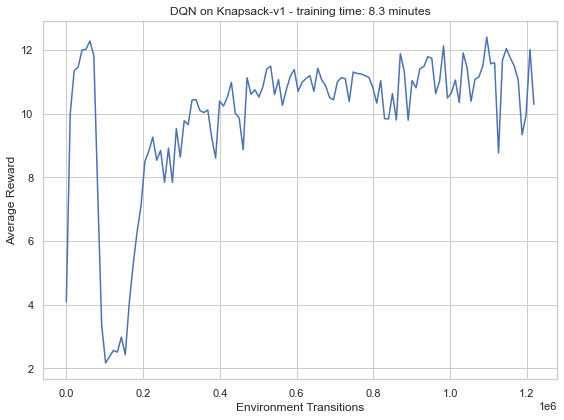

In [9]:
%matplotlib inline
sns.set(style="whitegrid")

num_env_transitions = ROLLOUT_LEN*TRAINING_ITERS*TRAINING_EVAL_ITERS
x_values = np.asarray(jnp.arange(0, num_env_transitions, num_env_transitions/len(avg_reward)))
avg_reward = np.asarray(avg_reward)

plt.figure(figsize=(8,6))
sns.lineplot(x=x_values, y=avg_reward)
plt.xlabel('Environment Transitions')
plt.ylabel('Average Reward')
plt.title(f'DQN on Knapsack-v1 - training time: {np.round((total_time)/60, 2)} minutes')

plt.tight_layout()
plt.show()